In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import pickle
import torch
import io
import random
from gensim.models import Word2Vec

In [2]:
# function to work around loading a GPU generated pickle on local CPU machine
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [3]:
# load synthesizer from saved object
with open('models/TVAE_synthesizer_10emb_noCat_ageCat_0.1M.pkl', 'rb') as input:
    synthesizer = CPU_Unpickler(input).load()

# modify device from cuda:0 to cpu
synthesizer.device = 'cpu'

In [4]:
# load synthesizer from local machine
#with open('models/TVAE_synthesizer_test.pkl', 'rb') as input:
#    synthesizer = pickle.load(input)

In [5]:
# check out sample
N = 10000
sample = synthesizer.sample(N)
np.set_printoptions(suppress = True, precision = 2)

In [6]:
df_input = pd.read_csv('data/cc_data_input_10emb_ageCat.csv')

In [7]:
input_columns = list(df_input.columns)[1:]

In [8]:
df_sample = pd.DataFrame(sample, columns=input_columns) 
pd.set_option('display.max_columns', 36)
df_sample.head()

,Purchase Amount,Account Type_bank_account,Account Type_credit_card,Consumer Gender_female,Consumer Gender_male,SIC Description_Book Stores,"SIC Description_Communications Services, Not Elsewhere Classified",SIC Description_Drug Stores and Proprietary Stores,SIC Description_Eating Places,SIC Description_Family Clothing Stores,SIC Description_Gasoline Service Stations,SIC Description_Grocery Stores,SIC Description_Miscellaneous Food Stores,SIC Description_Other,SIC Description_Taxicabs,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,...,"Age Range_(45, 50]","Age Range_(50, 55]","Age Range_(55, 60]","Age Range_(60, 65]","Age Range_(65, 70]","Age Range_(70, 75]","Age Range_(75, 80]","Age Range_(80, 90]",retailerVec_01,retailerVec_02,retailerVec_03,retailerVec_04,retailerVec_05,retailerVec_06,retailerVec_07,retailerVec_08,retailerVec_09,retailerVec_10
0,15.815616,0.997722,0.000980,0.998908,0.001650,0.000083,0.000082,-0.000008,-0.000047,-0.000017,0.000031,0.000670,0.000046,-0.000355,-0.000289,0.000043,0.000156,-0.001024,...,0.000527,-0.000153,0.000068,-0.000392,-0.000276,0.000259,-0.000032,-0.000168,0.215234,-0.852432,0.293385,0.500638,-0.669313,-1.452693,-1.001274,-2.459175,-0.538566,-0.538810
1,15.489267,0.999065,0.001723,1.001024,0.000346,-0.000352,0.000044,0.000473,-0.000064,0.000469,-0.000528,0.000188,0.000329,0.000148,-0.000064,0.000566,0.000917,0.000138,...,0.000885,0.000760,0.000402,0.000484,-0.000221,-0.000119,0.000174,-0.000067,0.580307,-0.509730,0.373571,0.521203,-0.672669,-1.851270,-0.603080,-0.500516,-0.684695,-0.640837
2,9.204700,0.999823,0.003449,0.998540,0.001259,-0.000104,0.000156,0.000141,0.000073,-0.001704,0.000223,0.000510,0.000023,0.000040,-0.000122,0.000293,0.001548,-0.000026,...,0.001084,0.000254,-0.000013,0.000126,0.000491,-0.000016,0.000157,-0.000126,-0.127787,-0.642954,0.418927,0.409367,-0.655999,-2.070240,-0.452354,-0.454332,-0.119569,-1.070318
3,5.328971,0.998804,0.000404,0.997308,0.002321,-0.000250,-0.000059,-0.000021,-0.000108,-0.000033,0.000692,0.001000,-0.000335,0.001301,-0.000115,0.000876,-0.000993,-0.000195,...,0.000736,0.000477,0.000475,0.000019,-0.000061,0.000036,0.000011,0.000349,0.160332,-0.715201,0.296031,0.295006,-0.347749,-1.802965,-0.604130,-2.746915,-0.439640,-0.968790
4,12.917674,0.998367,0.001810,0.998400,-0.000914,0.000086,0.000060,-0.000064,-0.000292,0.000371,-0.000602,0.000599,0.000156,0.000270,-0.000587,0.000048,0.000697,0.000339,...,-0.000137,0.000346,0.000201,0.000191,-0.000185,0.000085,0.000009,-0.000018,0.037550,-0.543686,0.224450,0.554802,-0.229531,-2.174359,-0.066687,-2.387399,-0.400880,-0.370201


In [9]:
# return series of dummy variables with given column name
def reverse_dummy(df, col_name):
    # get index of columns that starts with col_name, for example, Gender_male, Gender_female for col_name = `Gender`
    idx = [i for i, s in enumerate(list(df.columns)) if col_name in s]
    tmp = df.iloc[:,idx]
    # find column name for max in each row and put into one series
    df_output = pd.Series(tmp.idxmax(axis=1), name = col_name)
    
    # remove strings with col_name plus underscore
    df_output = df_output.map(lambda x: x.replace(col_name + '_',''))
    return df_output

In [10]:
df_purchase = df_sample.iloc[:,[0]]
df_age = reverse_dummy(df_sample,'Age Range')
df_account = reverse_dummy(df_sample,'Account Type')
df_gender = reverse_dummy(df_sample,'Consumer Gender')
df_SIC = reverse_dummy(df_sample,'SIC Description')
df_dw = reverse_dummy(df_sample,'day_of_week')
df_pm = reverse_dummy(df_sample,'period_of_month')

In [11]:
df_reverse = pd.concat([df_purchase,df_age,df_account,df_gender,df_SIC,df_dw,df_pm], axis=1)

# remove negative purchase amount
df_reverse = df_reverse[(df_reverse['Purchase Amount'] > 0)]
df_reverse.reset_index(drop=True, inplace=True)

#pd.set_option('display.max_rows', N)
print(df_reverse.shape)
df_reverse.head()

(9501, 7)


,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month
0,15.815616,"(35, 40]",bank_account,female,Grocery Stores,Tuesday,end
1,15.489267,"(35, 40]",bank_account,female,Drug Stores and Proprietary Stores,Monday,mid
2,9.204700,"(45, 50]",bank_account,female,Grocery Stores,Monday,mid
3,5.328971,"(30, 35]",bank_account,female,Other,Friday,start
4,12.917674,"(30, 35]",bank_account,female,Grocery Stores,Sunday,mid


In [12]:
def return_age(age_range):
    age_range = age_range.replace('(','').replace(']','').replace(' ','')
    r1 = int(age_range.split(',')[0])
    r2 = int(age_range.split(',')[1])
    return random.choice(list(range(r1+1, r2+1)))

In [13]:
df_reverse['Age'] = df_reverse.apply(lambda x: return_age(x['Age Range']), axis = 1)
df_reverse.head()

,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Age
0,15.815616,"(35, 40]",bank_account,female,Grocery Stores,Tuesday,end,36
1,15.489267,"(35, 40]",bank_account,female,Drug Stores and Proprietary Stores,Monday,mid,37
2,9.204700,"(45, 50]",bank_account,female,Grocery Stores,Monday,mid,50
3,5.328971,"(30, 35]",bank_account,female,Other,Friday,start,33
4,12.917674,"(30, 35]",bank_account,female,Grocery Stores,Sunday,mid,33


In [14]:
#df_reverse['SIC Description'].value_counts().index.to_list()

In [15]:
# reverse retailerVec back to retailers
idx = [i for i, s in enumerate(list(df_sample.columns)) if 'retailerVec' in s]
df_retailerVec = df_sample.iloc[:,idx]

# load the retailer_map
with open('models/retailer_map.pkl', 'rb') as input:
    retailer_map = pickle.load(input)    

model = Word2Vec.load('models/perSICperPerson_10emb.model')
    
# only keep values in the model (more than 5 times appearance)
for key, value in retailer_map.items():
    retailer_map[key] = list(set(value) & set(model.wv.vocab))
    
# group other SIC (after top N) into other
list2keep = ['Eating Places', 'Grocery Stores', 'Gasoline Service Stations', 'Book Stores', 'Drug Stores and Proprietary Stores', 'Miscellaneous Food Stores', 'Family Clothing Stores', 'Taxicabs', 'Communications Services, Not Elsewhere Classified']
other_list = []    
for key, value in retailer_map.items():
    if key not in list2keep:
        other_list = other_list + value

# delete other group key-values in retailer_map
retailer_map_grouped = {k: retailer_map[k] for k in list2keep}

# add other key-value pairs
retailer_map_grouped['Other'] = other_list

# put retailer vectors into one column
df_retailerVec['retailerVec']= df_retailerVec.values.tolist()
df_SIC_vector = pd.concat([df_SIC,df_retailerVec['retailerVec']],axis = 1)
df_SIC_vector.head()

d:\anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,SIC Description,retailerVec
0,Grocery Stores,"[0.2152344822062597, -0.8524324042907545, 0.29..."
1,Drug Stores and Proprietary Stores,"[0.5803074910386172, -0.5097298107728736, 0.37..."
2,Grocery Stores,"[-0.1277868226903524, -0.6429536326070063, 0.4..."
3,Other,"[0.160331511762262, -0.7152008713048779, 0.296..."
4,Grocery Stores,"[0.037550273490484454, -0.5436861842202217, 0...."


In [16]:
retailer_map_grouped.keys()
#retailer_map_grouped['Radiotelephone Communications']
#df_SIC_vector['SIC Description'].value_counts()

dict_keys(['Eating Places', 'Grocery Stores', 'Gasoline Service Stations', 'Book Stores', 'Drug Stores and Proprietary Stores', 'Miscellaneous Food Stores', 'Family Clothing Stores', 'Taxicabs', 'Communications Services, Not Elsewhere Classified', 'Other'])

In [17]:
# find out retailer in the same SIC and also with the most similar vector
def return_retailer_SIC(model, retailer_map_grouped, sector, vector):
    if pd.isnull(sector):
        return None
    else:
        word_list = retailer_map_grouped[sector]
        min_idx = model.wv.distances(vector, other_words = word_list).argmin()
        return word_list[min_idx]

In [18]:
df_reverse['Normalized Retailer'] = df_SIC_vector.apply(lambda x: return_retailer_SIC(model, retailer_map_grouped, x['SIC Description'],x['retailerVec']), axis = 1)
df_reverse.head()

,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Age,Normalized Retailer
0,15.815616,"(35, 40]",bank_account,female,Grocery Stores,Tuesday,end,36,Foodworld
1,15.489267,"(35, 40]",bank_account,female,Drug Stores and Proprietary Stores,Monday,mid,37,Pharmasave
2,9.204700,"(45, 50]",bank_account,female,Grocery Stores,Monday,mid,50,H Mart
3,5.328971,"(30, 35]",bank_account,female,Other,Friday,start,33,Clinique.
4,12.917674,"(30, 35]",bank_account,female,Grocery Stores,Sunday,mid,33,Halal Meat Shop


In [19]:
# given period_of_month (start, mid or end) and year (1989) and month (6), return index of the possible days
def return_day_index(period_of_month, year, month):
    if period_of_month == 'start':
        return list(range(1,11))
    elif period_of_month == 'mid':
        return list(range(11,21))
    else:
        return list(range(21, pd.Period(str(year) + '-' + str(month)).days_in_month + 1))
    
# function to convert day_of_week and period_of_month back to Date, given a year and a month
# Example:
# input: day_of_week = 'Monday'; period_of_month = 'start'; Y = 2020; M = 2
# output: 2020-02-03 00:00:00

def return_date(day_of_week, period_of_month, Y, M):
    # return list of days
    D = return_day_index(period_of_month, Y, M)

    tmp = pd.DataFrame({'year': [str(Y) for i in range(len(D))],
                        'month': [str(M) for i in range(len(D))],
                        'day': D})
    
    # create table with each row of year, month and day in given period
    date_period = pd.to_datetime(tmp[['year', 'month', 'day']])

    # locate index of which date is the given day_of_week
    idx_list = [i for i, s in enumerate(date_period.dt.strftime('%A')) if day_of_week in s]

    # randomly pick up one index, since it's possible one period has multiple given weekday (say Monday)
    idx = random.choice(idx_list)

    return date_period[idx]

In [20]:
Y = 2022; M = 2
df_reverse['Transaction Date'] = df_reverse.apply(lambda x: return_date(x.day_of_week, x.period_of_month, Y, M), axis = 1)
#df_reverse.drop(['day_of_week','period_of_month'], axis = 1, inplace = True, errors = 'ignore')
df_reverse.head()

,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Age,Normalized Retailer,Transaction Date
0,15.815616,"(35, 40]",bank_account,female,Grocery Stores,Tuesday,end,36,Foodworld,2022-02-22
1,15.489267,"(35, 40]",bank_account,female,Drug Stores and Proprietary Stores,Monday,mid,37,Pharmasave,2022-02-14
2,9.204700,"(45, 50]",bank_account,female,Grocery Stores,Monday,mid,50,H Mart,2022-02-14
3,5.328971,"(30, 35]",bank_account,female,Other,Friday,start,33,Clinique.,2022-02-04
4,12.917674,"(30, 35]",bank_account,female,Grocery Stores,Sunday,mid,33,Halal Meat Shop,2022-02-20


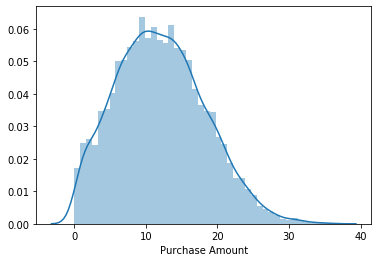

In [21]:
sns.distplot(df_reverse['Purchase Amount']);
#plt.savefig('figs/eda/purchase_hist_syn.png',bbox_inches='tight')

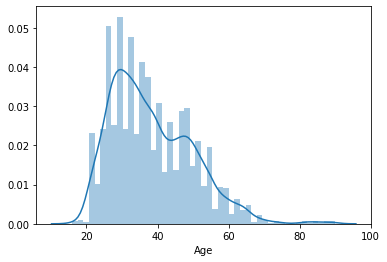

In [22]:
sns.distplot(df_reverse['Age']);
#plt.savefig('figs/eda/age_hist_syn.png',bbox_inches='tight')

In [23]:
# view counts and percentage for each column's elements
def view_column_counts(df, col_name):
    df_pivot = df.groupby(by = col_name).size().reset_index(name='Counts')
    df_pivot['Per (%)'] = (df_pivot['Counts'])/df.shape[0]*100
    df_pivot.sort_values(by = 'Counts',ascending = False,inplace = True)
    return df_pivot

In [24]:
# gender, account type, sector and retailer percentage
text_col_list = ['Account Type', 'Consumer Gender','Normalized Retailer', 'SIC Description']

for col_name in text_col_list:   
    print(col_name)
    df_pivot = view_column_counts(df_reverse,col_name)
    print(df_pivot)
    print('\n')

Account Type
   Account Type  Counts    Per (%)
0  bank_account    8644  90.979897
1   credit_card     857   9.020103


Consumer Gender
  Consumer Gender  Counts    Per (%)
0          female    9287  97.747606
1            male     214   2.252394


Normalized Retailer
        Normalized Retailer  Counts    Per (%)
46                Clinique.    1327  13.966951
170                    Sail     868   9.135880
75                 GAP Kids     746   7.851805
185  Spotless Dry Clearners     585   6.157247
10          Banana Republic     462   4.862646
..                      ...     ...        ...
109          La Belle Verte       1   0.010525
106            Koodo Mobile       1   0.010525
103    Khao Thai Restaurant       1   0.010525
102               Kasa Moto       1   0.010525
231              eShopWorld       1   0.010525

[232 rows x 3 columns]


SIC Description
                                     SIC Description  Counts    Per (%)
4                             Family Clothing Stores 

barplot for SIC Description


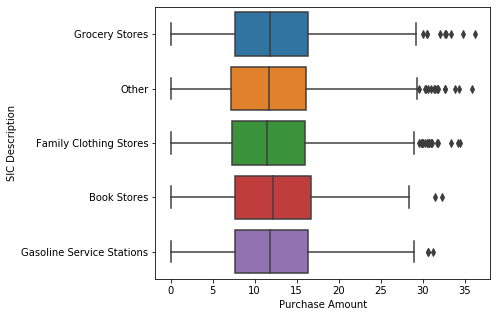

barplot for Normalized Retailer


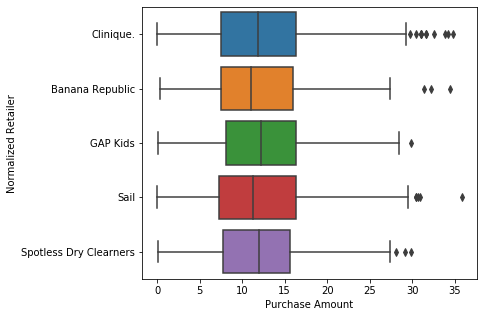

In [25]:
check_list = ['SIC Description','Normalized Retailer']
fig_dims = [6, 5] 
N = 5
threshold = 100

for cat in check_list:   
    print("barplot for %s" % (cat))
    list_tmp = df_reverse[cat].value_counts()[:N].index.tolist() # top N counts in that category
    df_tmp = df_reverse[df_reverse[cat].isin(list_tmp) & (df_reverse['Purchase Amount'] < threshold)]
    fig, ax = plt.subplots(figsize = fig_dims)
    chart = sns.boxplot(y = df_tmp[cat], x = df_tmp['Purchase Amount'])
    plt.show()